# Fuzzy Logic for Sleep Efficiency Dataset

**Inputs:**
- Sleep duration
- Caffeine consumption
- Alcohol consumption
- Exercise frequency
- Awakenings

**Output:**
- Sleep quality score (0–100)
- Sleep quality label (poor / fair / good)
- Recommended sleep extension (hours)

In [1]:
!pip install scikit-fuzzy pandas numpy matplotlib

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from skfuzzy import control as ctrl

df = pd.read_csv("data.csv")
df = df.dropna().reset_index(drop=True)
df.head()

,ID,Age,Gender,Bedtime,Wakeup time,Sleep duration,Sleep efficiency,REM sleep percentage,Deep sleep percentage,Light sleep percentage,Awakenings,Caffeine consumption,Alcohol consumption,Smoking status,Exercise frequency
0,1,65,Female,2021-03-06 01:00:00,2021-03-06 07:00:00,6.0,0.88,18,70,12,0.0,0.0,0.0,Yes,3.0
1,2,69,Male,2021-12-05 02:00:00,2021-12-05 09:00:00,7.0,0.66,19,28,53,3.0,0.0,3.0,Yes,3.0
2,3,40,Female,2021-05-25 21:30:00,2021-05-25 05:30:00,8.0,0.89,20,70,10,1.0,0.0,0.0,No,3.0
3,4,40,Female,2021-11-03 02:30:00,2021-11-03 08:30:00,6.0,0.51,23,25,52,3.0,50.0,5.0,Yes,1.0
4,5,57,Male,2021-03-13 01:00:00,2021-03-13 09:00:00,8.0,0.76,27,55,18,3.0,0.0,3.0,No,3.0


In [3]:

# Variable input
sleep = ctrl.Antecedent(np.arange(0, 13, 0.1), 'sleep_duration')
caffeine = ctrl.Antecedent(np.arange(0, 500, 1), 'caffeine')
alcohol = ctrl.Antecedent(np.arange(0, 20, 0.1), 'alcohol')
exercise = ctrl.Antecedent(np.arange(0, 8, 1), 'exercise')
awaken = ctrl.Antecedent(np.arange(0, 10, 1), 'awakenings')

# Variable output
quality = ctrl.Consequent(np.arange(0, 101, 1), 'sleep_quality_score')

# Membership functions
sleep['short'] = fuzz.trapmf(sleep.universe, [0,0,4.5,6])
sleep['optimal'] = fuzz.trimf(sleep.universe, [5.5,7,8.5])
sleep['long'] = fuzz.trapmf(sleep.universe, [8,9,12,12])

caffeine['low'] = fuzz.trapmf(caffeine.universe, [0,0,50,150])
caffeine['medium'] = fuzz.trimf(caffeine.universe, [100,200,300])
caffeine['high'] = fuzz.trapmf(caffeine.universe, [250,400,500,500])

alcohol['none'] = fuzz.trapmf(alcohol.universe, [0,0,0.5,2])
alcohol['moderate'] = fuzz.trimf(alcohol.universe, [1.5,4,7])
alcohol['high'] = fuzz.trapmf(alcohol.universe, [6,10,20,20])

exercise['low'] = fuzz.trapmf(exercise.universe, [0,0,1,3])
exercise['moderate'] = fuzz.trimf(exercise.universe, [2,3.5,5])
exercise['high'] = fuzz.trapmf(exercise.universe, [4.5,6,7,7])

awaken['few'] = fuzz.trapmf(awaken.universe, [0,0,1,2])
awaken['moderate'] = fuzz.trimf(awaken.universe, [1.5,3,5])
awaken['frequent'] = fuzz.trapmf(awaken.universe, [4,6,10,10])

quality['poor'] = fuzz.trapmf(quality.universe, [0,0,30,45])
quality['fair'] = fuzz.trimf(quality.universe, [40,60,80])
quality['good'] = fuzz.trapmf(quality.universe, [70,85,100,100])


In [4]:
rule1 = ctrl.Rule(sleep['short'] | awaken['frequent'] | caffeine['high'] | alcohol['high'], quality['poor'])
rule2 = ctrl.Rule(sleep['optimal'] & exercise['moderate'] & caffeine['low'] & awaken['few'], quality['good'])
rule3 = ctrl.Rule(sleep['optimal'] & (alcohol['moderate'] | caffeine['medium']), quality['fair'])
rule4 = ctrl.Rule(sleep['long'] & alcohol['none'], quality['fair'])
rule5 = ctrl.Rule(exercise['low'] & awaken['moderate'], quality['poor'])

system = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5])
sim = ctrl.ControlSystemSimulation(system)

In [5]:
scores = []
for _, row in df.iterrows():
    sim.input['sleep_duration'] = row['Sleep duration']
    sim.input['caffeine'] = row['Caffeine consumption']
    sim.input['alcohol'] = row['Alcohol consumption']
    sim.input['exercise'] = row['Exercise frequency']
    sim.input['awakenings'] = row['Awakenings']
    try:
        sim.compute()
        scores.append(sim.output['sleep_quality_score'])
    except:
        scores.append(np.nan)

# Label kategori berdasarkan rentang skor
# 0–45  = 'poor' (buruk)
# 46–75 = 'fair' (sedang)
# 76–100= 'good' (baik)
df['sleep_quality_score'] = np.round(scores,2)
df['sleep_quality_label'] = pd.cut(df['sleep_quality_score'],
                                   bins=[-1,45,75,100],
                                   labels=['poor','fair','good'])

# Rekomendasi tambahan durasi tidur (jam) berdasarkan label kualitas
# - Jika 'poor' → tambah 1.5 jam
# - Jika 'fair' → tambah 0.5 jam
# - Jika 'good' → tidak perlu tambahan
df['recommended_sleep_extension_h'] = df['sleep_quality_label'].apply(
    lambda x: 1.5 if x=='poor' else (0.5 if x=='fair' else 0))

df.head()

,ID,Age,Gender,Bedtime,Wakeup time,Sleep duration,Sleep efficiency,REM sleep percentage,Deep sleep percentage,Light sleep percentage,Awakenings,Caffeine consumption,Alcohol consumption,Smoking status,Exercise frequency,sleep_quality_score,sleep_quality_label,recommended_sleep_extension_h
0,1,65,Female,2021-03-06 01:00:00,2021-03-06 07:00:00,6.0,0.88,18,70,12,0.0,0.0,0.0,Yes,3.0,86.21,good,0.0
1,2,69,Male,2021-12-05 02:00:00,2021-12-05 09:00:00,7.0,0.66,19,28,53,3.0,0.0,3.0,Yes,3.0,60.00,fair,0.5
2,3,40,Female,2021-05-25 21:30:00,2021-05-25 05:30:00,8.0,0.89,20,70,10,1.0,0.0,0.0,No,3.0,86.21,good,0.0
3,4,40,Female,2021-11-03 02:30:00,2021-11-03 08:30:00,6.0,0.51,23,25,52,3.0,50.0,5.0,Yes,1.0,28.27,poor,1.5
4,5,57,Male,2021-03-13 01:00:00,2021-03-13 09:00:00,8.0,0.76,27,55,18,3.0,0.0,3.0,No,3.0,60.00,fair,0.5


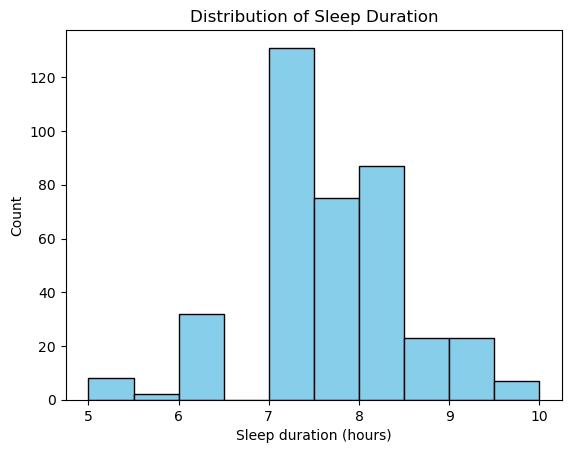

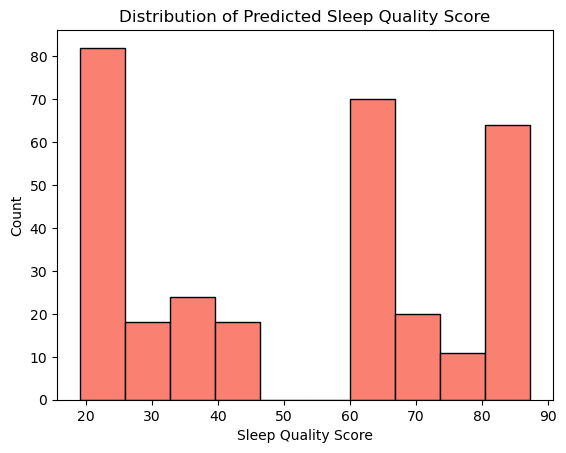

In [6]:
# Visualisasi: Durasi Tidur
plt.figure()
plt.hist(df['Sleep duration'], bins=10, color='skyblue', edgecolor='black')
plt.title('Distribution of Sleep Duration')
plt.xlabel('Sleep duration (hours)')
plt.ylabel('Count')
plt.show()
# Penjelasan:
# Grafik ini menunjukkan frekuensi durasi tidur dari data.
# Terlihat berapa banyak orang yang tidur di rentang jam tertentu (misal 5–7 jam, 8–10 jam, dst).

# Visualisasi: Skor Kualitas Tidur
plt.figure()
plt.hist(df['sleep_quality_score'].dropna(), bins=10, color='salmon', edgecolor='black')
plt.title('Distribution of Predicted Sleep Quality Score')
plt.xlabel('Sleep Quality Score')
plt.ylabel('Count')
plt.show()
# Penjelasan:
# Grafik ini memperlihatkan distribusi skor kualitas tidur hasil perhitungan fuzzy.
# Semakin tinggi skor (mendekati 100), maka semakin baik kualitas tidurnya.
# Pola ini membantu melihat apakah data cenderung ke kategori 'poor', 'fair', atau 'good'.

In [7]:
# Simpan Hasil 
df.to_csv('fuzzy_sleep_efficiency_results.csv', index=False)
print('Saved fuzzy_sleep_efficiency_results.csv')

Saved fuzzy_sleep_efficiency_results.csv


In [8]:
!pip freeze > requirements.txt